## Earthquake Magnitude Scale 

[https://www.mtu.edu/geo/community/seismology/learn/earthquake-measure/magnitude/](https://www.mtu.edu/geo/community/seismology/learn/earthquake-measure/magnitude/)

| Magnitude     | Earthquake Effects                                                               | Estimated Number Each Year |
|---------------|----------------------------------------------------------------------------------|-----------------------------|
| 2.5 or less   | Usually not felt, but can be recorded by seismograph.                             | Millions                    |
| 2.5 to 5.4    | Often felt, but only causes minor damage.                                        | 500,000                     |
| 5.5 to 6.0    | Slight damage to buildings and other structures.                                 | 350                         |
| 6.1 to 6.9    | May cause a lot of damage in very populated areas.                               | 100                         |
| 7.0 to 7.9    | Major earthquake. Serious damage.                                                | 10-15                       |
| 8.0 or greater| Great earthquake. Can totally destroy communities near the epicenter.           | One every year or two       |



## Earthquake Data

[https://earthquake.usgs.gov/earthquakes/search/](https://earthquake.usgs.gov/earthquakes/search/)

In [1]:
from requests import get

url = "https://earthquake.usgs.gov/fdsnws/event/1/query.geojson?starttime=2023-03-12%2000%3A00%3A00&endtime=2023-04-12%2023%3A59%3A59&maxlatitude=90&minlatitude=-90&maxlongitude=180&minlongitude=-180&minmagnitude=4&orderby=time"
response = get(url)

if response.status_code == 200:
    response = response.json()
    features = response['features']
    print("\nSuccess!\n")
    print(f'{len(features)} earthquakes found.\n')


Success!

1243 earthquakes found.



In [2]:
from datetime import datetime
from urllib import parse
from tabulate import tabulate

urlParams = dict({
    'startTime': 'starttime',
    'endTime': 'endtime',
    'maxLatitude': 'maxlatitude',
    'minLatitude': 'minlatitude',
    'maxLongitude': 'maxlongitude',
    'minLongitude': 'minlongitude',
    'minMagnitude': 'minmagnitude',
    'orderBy': 'orderby'
})

def parse_url_segment(url, delimiter):
    return parse.unquote(url.split(delimiter)[1].split("&")[0])


def parse_url(url):
    obj = dict(urlParams)

    for key in obj:
        obj[key] = parse_url_segment(url, obj[key] + "=")

        if (key == 'startTime' or key == 'endTime'):
            obj[key] = datetime.strptime(obj[key], "%Y-%m-%d %H:%M:%S")

        if (key == 'maxLatitude' or key == 'minLatitude' or key == 'maxLongitude' or key == 'minLongitude' or key == 'minMagnitude'):
            obj[key] = float(obj[key])

    return obj

def create_table_from_params(urlParams): 
    table = []
    for key, value in urlParams.items():
        if isinstance(value, datetime):
            value = value.strftime('%Y-%m-%d %H:%M:%S')
        else:
            value = str(value)
        table.append((key, value))
    return tabulate(table, headers=['Parameter', 'Value'], tablefmt='grid')

global url
urlParams = parse_url(url)
table = create_table_from_params(urlParams)
print(table)

+--------------+---------------------+
| Parameter    | Value               |
+==============+=====================+
| startTime    | 2023-03-12 00:00:00 |
+--------------+---------------------+
| endTime      | 2023-04-12 23:59:59 |
+--------------+---------------------+
| maxLatitude  | 90.0                |
+--------------+---------------------+
| minLatitude  | -90.0               |
+--------------+---------------------+
| maxLongitude | 180.0               |
+--------------+---------------------+
| minLongitude | -180.0              |
+--------------+---------------------+
| minMagnitude | 4.0                 |
+--------------+---------------------+
| orderBy      | time                |
+--------------+---------------------+


In [3]:
# input
YEARS_TO_COLLECT = 80
MIN_MAGNITUDE = 3
FILE_NAME = 'earthquakes' # without extension

In [4]:
from datetime import timedelta

urlParams['minMagnitude'] = MIN_MAGNITUDE
urlParams['endTime'] = datetime.now()
urlParams['startTime'] = urlParams['endTime'] - \
    timedelta(weeks=YEARS_TO_COLLECT*52)

table = create_table_from_params(urlParams)
print(table)

+--------------+---------------------+
| Parameter    | Value               |
+==============+=====================+
| startTime    | 1944-11-30 12:17:43 |
+--------------+---------------------+
| endTime      | 2024-08-22 12:17:43 |
+--------------+---------------------+
| maxLatitude  | 90.0                |
+--------------+---------------------+
| minLatitude  | -90.0               |
+--------------+---------------------+
| maxLongitude | 180.0               |
+--------------+---------------------+
| minLongitude | -180.0              |
+--------------+---------------------+
| minMagnitude | 3                   |
+--------------+---------------------+
| orderBy      | time                |
+--------------+---------------------+


In [5]:
import pandas as pd
from concurrent.futures import ThreadPoolExecutor

cols = ['magnitude', 'time', 'latitude', 'longitude', 'depth']
df = pd.DataFrame(columns=cols)

def append_earthquakes_to_dataframe(features):
    global df
    global cols
    temp_df = pd.DataFrame(columns=cols)
    for earthquake in features:
        magnitude = earthquake['properties']['mag']
        time = earthquake['properties']['time']
        latitude = earthquake['geometry']['coordinates'][1]
        longitude = earthquake['geometry']['coordinates'][0]
        depth = earthquake['geometry']['coordinates'][2]

        temp_df.loc[len(temp_df)] = [magnitude, time, latitude, longitude, depth]
    
    if (len(df) == 0):
        df = temp_df
        return
    if (len(temp_df) > 0):
        df = pd.concat([df, temp_df], ignore_index=True)
        return

def fetch_earthquake_data(stepParams):
     url = f"https://earthquake.usgs.gov/fdsnws/event/1/query.geojson?starttime={stepParams['startTime']}&endtime={stepParams['endTime']}&maxlatitude={stepParams['maxLatitude']}&minlatitude={stepParams['minLatitude']}&maxlongitude={stepParams['maxLongitude']}&minlongitude={stepParams['minLongitude']}&minmagnitude={stepParams['minMagnitude']}&orderby={stepParams['orderBy']}"
     response = get(url)

     if response.status_code == 200:
        features = response.json()['features']

        if len(features) == 20000:
            print(f"Data for time range {stepParams['startTime']} to {stepParams['endTime']} is incomplete. Try a smaller time range.")

        append_earthquakes_to_dataframe(features)
     else:
        print(f"Error fetching data for time range {stepParams['startTime']} to {stepParams['endTime']}: {response.status_code}")

def get_earthquake_data(urlParams):
    timeStep = timedelta(0, 6 * 30 * 24 * 60 * 60) # 6 months

    intervals = []

    startTime = urlParams['startTime']
    endTime = startTime + timeStep
    
    while endTime <= urlParams['endTime']:
        interval = {
            'startTime': startTime,
            'endTime': endTime,
            'maxLatitude': urlParams['maxLatitude'],
            'minLatitude': urlParams['minLatitude'],
            'maxLongitude': urlParams['maxLongitude'],
            'minLongitude': urlParams['minLongitude'],
            'minMagnitude': urlParams['minMagnitude'],
            'orderBy': urlParams['orderBy']
        }
        intervals.append(interval)

        startTime = endTime + timedelta(0, 1)
        endTime = startTime + timeStep

    with ThreadPoolExecutor(max_workers=15) as executor:
        executor.map(fetch_earthquake_data, intervals)

get_earthquake_data(urlParams)

df.to_csv(FILE_NAME + '.csv')
print(f'\n{len(df)} earthquakes successfully exported to `{FILE_NAME}.csv.`')


731328 earthquakes successfully exported to `earthquakes.csv.`


In [21]:
IMPORT_FILE_NAME = 'earthquakes' # without extension

In [22]:
import pandas as pd

df = pd.read_csv(IMPORT_FILE_NAME + '.csv', index_col=0)

# convert time column to datetime and sort by datetime
df['datetime'] = pd.to_datetime(df['time'], unit='ms')
df = df.drop(columns=['time'])
df = df.sort_values(by='datetime')

/var/folders/rm/kc0nfkkn3sv4g2117pm5wz9w0000gn/T/ipykernel_33480/1138153150.py:9: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  bins = freq.resample('4M').size()


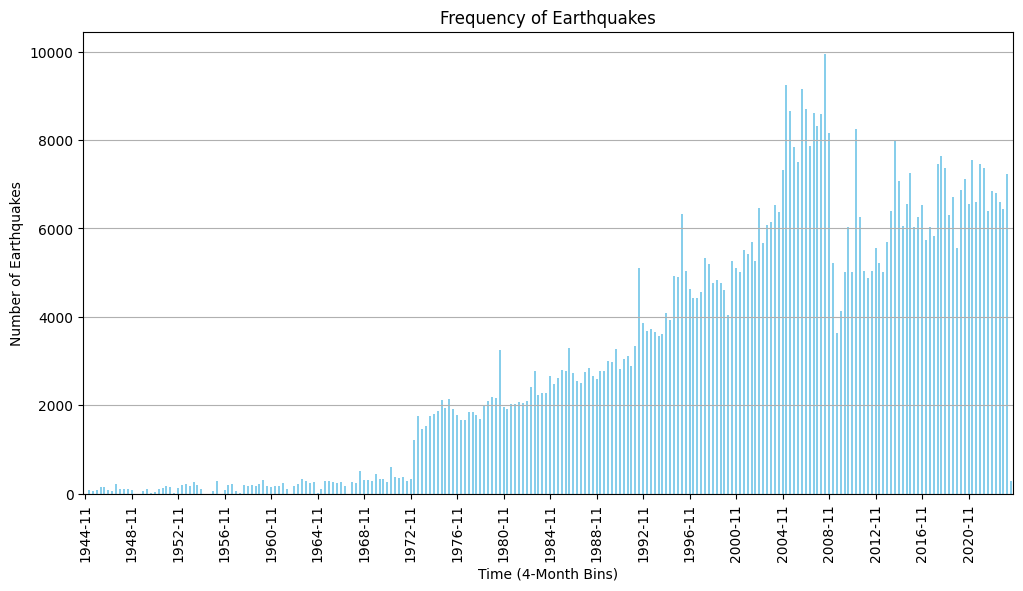

In [23]:
# earthquake frequency over time (histogram)
import matplotlib.pyplot as plt

# Set 'time' column as the index
freq = df.copy()
freq = freq.set_index('datetime')

# Resample the data to 4-month frequency and count the number of earthquakes in each 4-month period
bins = freq.resample('4M').size()

# Create a bar plot
plt.figure(figsize=(12, 6))
bins.plot(kind='bar', color='skyblue')
plt.title('Frequency of Earthquakes')
plt.xlabel('Time (4-Month Bins)')
plt.ylabel('Number of Earthquakes')
plt.grid(axis='y')
# Set x-tick positions to show every 12th tick
x_tick_positions = range(0, len(bins), 12)
plt.xticks(x_tick_positions, bins.index[x_tick_positions].strftime('%Y-%m'))
plt.show()

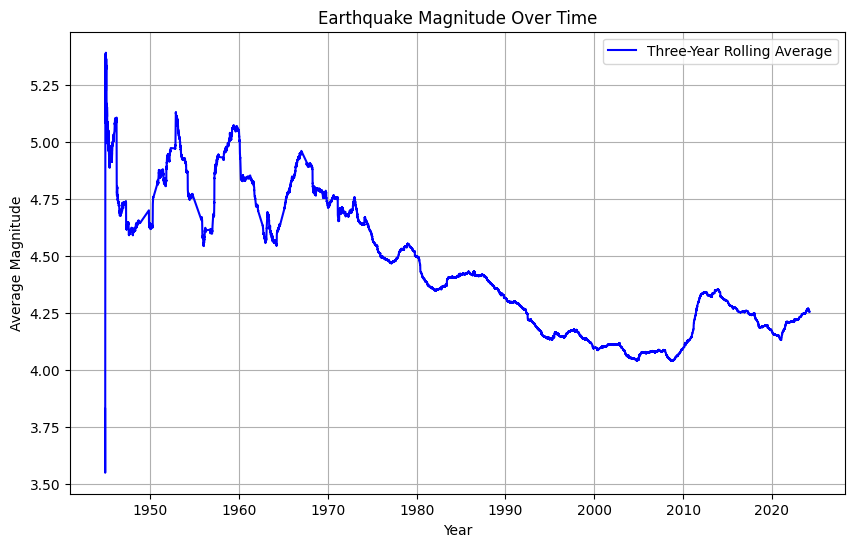

In [31]:
# earthquake magnitude over time (five year rolling average)
import matplotlib.pyplot as plt

# copy dataframe
mag = df.copy()
mag = mag.set_index('datetime')

# Calculate rolling average of 'magnitude'
rolling_average = mag.rolling(window=timedelta(days=365*3)).mean()

# Create the line plot
plt.figure(figsize=(10, 6))
plt.plot(rolling_average.index, rolling_average['magnitude'], label='Three-Year Rolling Average', color='blue')
plt.xlabel('Year')
plt.ylabel('Average Magnitude')
plt.title('Earthquake Magnitude Over Time')
plt.legend()
plt.grid(True)
plt.show()

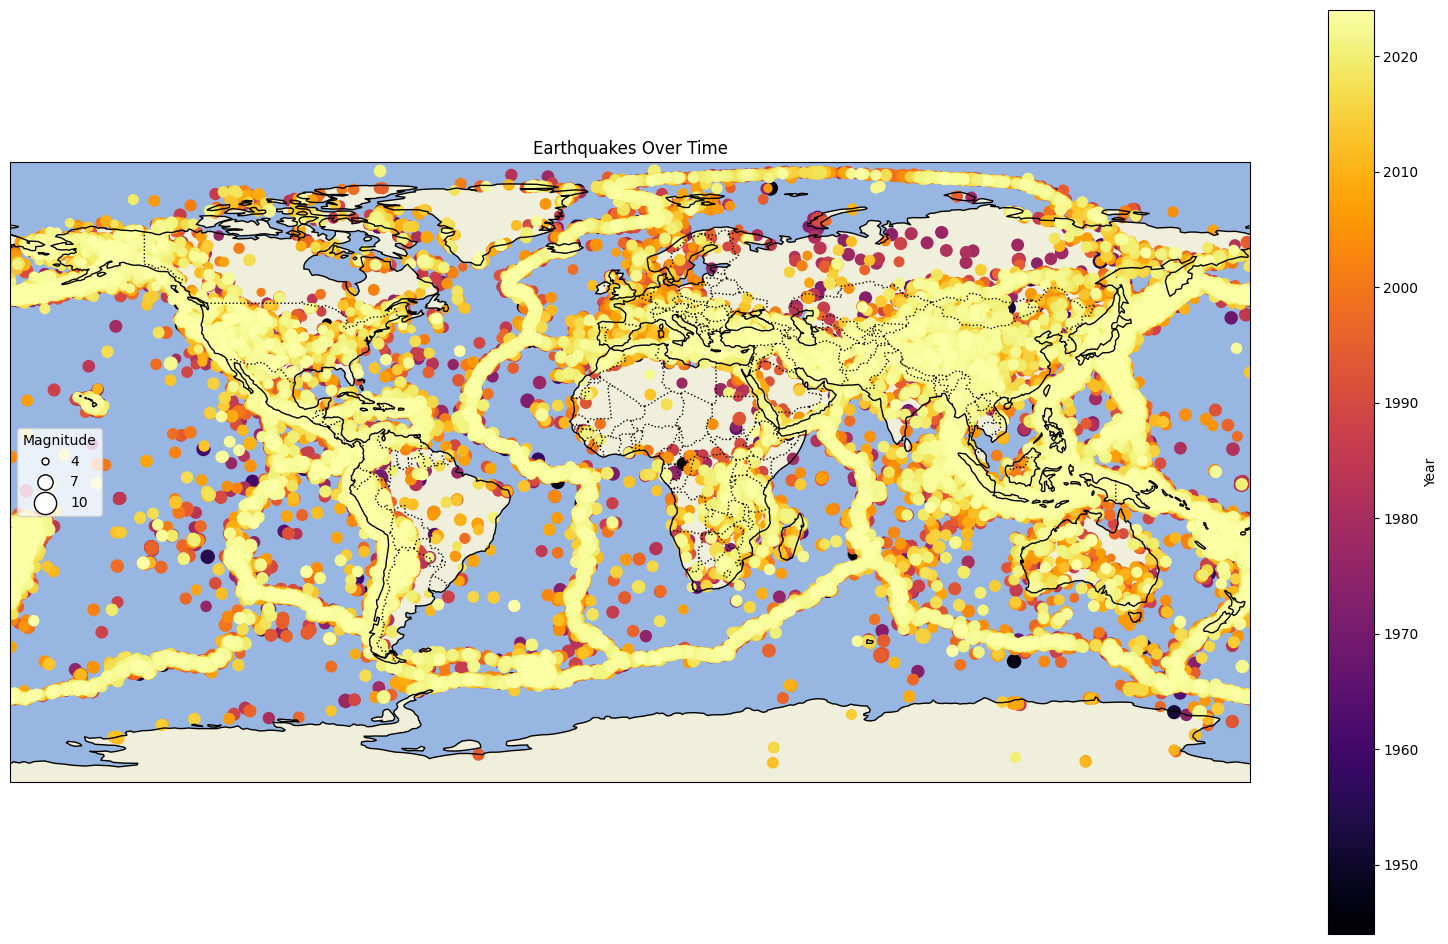

In [57]:
# earthquake location over time
import math
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# copy the DataFrame
loc = df.copy()

# scale the 'magnitude' values to determine marker sizes
min_magnitude = math.floor(loc['magnitude'].min())
max_magnitude = 10
def get_marker_size(magnitude: float):
    global min_magnitude
    global max_magnitude
    return 10 + 150 * (magnitude - min_magnitude) / (max_magnitude - min_magnitude)

marker_sizes = get_marker_size(loc['magnitude'])

# create marker size legend
def get_marker_legend_element(markersize: int, label: str):
    return plt.Line2D([0], [0], marker='o', color='k', markerfacecolor='w', markersize=markersize, label=label, linestyle='None')

legend_elements = [
    get_marker_legend_element(markersize=5, label='4'),
    get_marker_legend_element(markersize=11, label='7'),
    get_marker_legend_element(markersize=16, label='10')
]

def get_year(val):
    return val.year

# Create a plot with a map background
plt.figure(figsize=(20, 12))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.OCEAN)
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, linestyle=':')

# Scatter plot
scatter = ax.scatter(
    loc['longitude'], loc['latitude'], 
    c=pd.to_datetime(loc['datetime']).map(get_year), 
    cmap='inferno', 
    s=marker_sizes, 
    transform=ccrs.PlateCarree()
)

# Colorbar and legend
plt.colorbar(scatter, ax=ax, label='Year')
plt.legend(handles=legend_elements, loc='center left', title='Magnitude')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Earthquakes Over Time')
plt.grid(True)

plt.show()